In [320]:
# coding: utf-8

import lxml.etree
import os
from IPython.display import display
import pandas as pd
import sh
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [340]:
class BLText:
    FLICKR_TEMPLATE = 'https://www.flickr.com/photos/britishlibrary/tags/sysnum%s'
    # template below is magic - stolen from Flickr entry for BL photos
    BRITLIB_TEMPLATE = 'http://explore.bl.uk/primo_library/libweb/action/search.do?cs=frb&doc=BLL01%s&dscnt=1&scp.scps=scope:(BLCONTENT)&frbg=&tab=local_tab&srt=rank&ct=search&mode=Basic&dum=true&tb=t&indx=1&vl(freeText0)=%s&fn=search&vid=BLVU1'
    NAMESPACES = {'MODS': 'http://www.loc.gov/mods/v3'}
    
    def __init__(self, metadatafile): 
        self.metadatafile = metadatafile
        self.tree = lxml.etree.parse(self.metadatafile)
    
    def getText(self, xpath):
        out = self.tree.xpath(xpath + '/text()', namespaces=BLText.NAMESPACES)
        if isinstance(out, list): 
            if len(out) == 1: 
                # No sense having a list of length one. Get just the string. 
                out = out[0]
        return out

    @property
    def ID(self): 
        return self.getText('//MODS:recordInfo/MODS:recordIdentifier')
    
    @property
    def title(self):
        # TODO enable caching of this result
        return self.getText('//MODS:title')
        
#    def getTitle(self): 
#        return self.getText('//MODS:title')
        
    @property
    def author(self): 
        rawAuthor = self.getText('//MODS:name[@type="personal"]/MODS:namePart')
        # TODO: do some transformations to the text here. Get it in the appropriate case. 
        return rawAuthor

    @property
    def githubTitle(self):
        oldTitle = self.title
        textID = self.ID
        idLength = len(textID)
        if type(oldTitle) is list and len(oldTitle) > 0: 
            oldTitle = oldTitle[0] 
        try: 
            oldTitle = re.sub(r'[^\w\s-]','',oldTitle)
            titleNoSpace = oldTitle.replace(' ','-')
            ## need uniRecode function
            newTitle = titleNoSpace[:100-idLength]+textID
        except: 
            newTitle = None
        return newTitle
    
    @property
    def subjects(self): 
        return self.getText('//MODS:subject/*')

    @property
    def date(self):
        return self.getText('//MODS:originInfo/MODS:dateIssued')
        
    @property
    def cleanDate(self):
        oldDate = self.date
        if type(oldDate) is list and len(oldDate) > 0:             
            oldDate = oldDate[0]
        try:
            cleanDate = re.search(r'\d{4}', oldDate)
            cleanDate = cleanDate.group(0)
            cleanDate = int(cleanDate)
        except: 
            cleanDate = None #dirty hack
        return cleanDate
        
# A collection of BLText objects. 
class BLCorpus(): 
    def __init__(self, metadataDir):
        self.baseDir = metadataDir
        self.texts = []
        self.readDataDir()
        self.makeDataFrame()

    def readDataDir(self): 
        metadataFilenames = os.listdir(self.baseDir)
        self.texts = [ BLText(os.path.join(self.baseDir, metadataFilename)) for metadataFilename in metadataFilenames ]
        self.metadata = [ [ text.ID, text.title, text.author, text.githubTitle, text.subjects, text.date, text.cleanDate ] for text in self.texts ] 
    
    def makeDataFrame(self): 
        self.df = pd.DataFrame(self.metadata, columns=['ID', 'Title', 'Author', 'GitHub Title', 'Subjects', 'Date', 'CleanDate'])
        
    def show(self): 
        display(self.df)

#c = BLCorpus('data2')
#c.df
#c.texts[0].textdir


In [341]:
c = BLCorpus('metadata/metadata-files')

In [350]:
c.df

,ID,Title,Author,GitHub Title,Subjects,Date,CleanDate
0,001332821,"Der 14, 18 und 31 Oktober, drei grosse Gedenkt...","FRITSCHE, Ed.",Der-14-18-und-31-Oktober-drei-grosse-Gedenktag...,[],1864,1864
1,003783838,"Travels in Europe, Egypt, Arabia, Petraea, Pal...","VETROMILE, Eugene.",Travels-in-Europe-Egypt-Arabia-Petraea-Palesti...,[],1871,1871
2,001244684,Critical Period of American History ... Illust...,"[Fiske, John, 1842-1901]",Critical-Period-of-American-History--Illustrat...,[],1898,1898
3,002307440,Topography of Assam,"MACCOSH, John.",Topography-of-Assam002307440,"[Assam (India), Description and travel]",1837,1837
4,001466524,Notes from Another World,"[GORDON, Granville Armyne, Lord]",Notes-from-Another-World001466524,[],1886,1886
5,003508888,[Historiska Handlingar. [Ny följd.] del. 1-41...,[],Historiska-Handlingar-Ny-foljd-del-1-41003508888,[],1861-1979,1861
6,003778852,[Histoire générale des grands voyages et des...,"[Verne, Jules, 1828-1905, Verne, Jules,, 1828-...",Histoire-generale-des-grands-voyages-et-des-gr...,[],[1880],1880
7,003558122,"[Bothwell: a tragedy. [In verse.], Single Works]","[Swinburne, Algernon Charles., 1837-1909]",Bothwell-a-tragedy-In-verse003558122,[],1874,1874
8,000443744,Lost Towns of the Humber; with an introductory...,"BOYLE, John Roberts.",Lost-Towns-of-the-Humber-with-an-introductory-...,[],1889,1889
9,002112645,history of Lord Seaton's Regiment (the 52nd Li...,"[LEEKE, William., COLBORNE, John, Baron Seaton]",history-of-Lord-Seatons-Regiment-the-52nd-Ligh...,[],1866-71,1866


In [397]:
plt.figure()

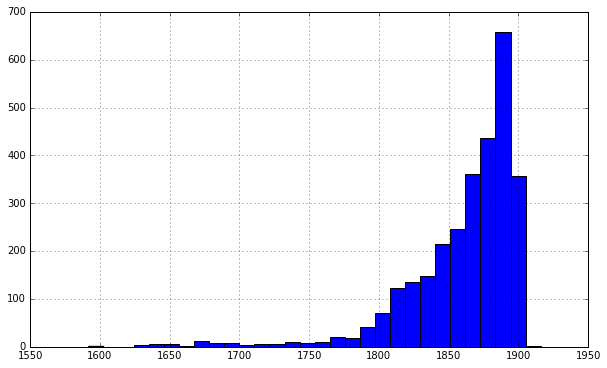

In [408]:
fig = c.df['CleanDate'][:3000].hist(bins=30, figsize=(10,6))

AttributeError: 'Text' object has no attribute 'set_ylabel'